---
layout: code-post
title: Training neural nets - What happens?
tags: [neural nets]
---

# What happens during training?

In this notebook post we're going to explore a little more about how training proceeds.
The previous post covered [initialization](https://kevinnowland.com/code/2020/05/16/initialization.html), 
and we will see how because of the carefully
chosen initialiation, the distribution of coefficients does not change much during
training. Then we visually, but not scientifically, investigate how coefficients
fluctuate during training as well how neurons change in "importance". We briefly
touch on some intuitive ways to rank neuron importance in a given layer in
anticipation of a future post on pruning neural nets and the lottery ticket 
hypothesis.

Then, the remainder of the notebook will be spent looking into one notion of distance
between neural networks and use this to investigate if a given architecture 
initialized in different ways converges to similar solutions. 
The answer in one seems to be now, differently initialized coefficients in the same
architecture converge to different minima. Perhaps in a future post we will see that
this is not entirely true, but for now, it seems to indicate that what we start with
an overdetermined system with many good regimes and we pick out just one of them.

Outline:
- Coefficient distribution changes
- Coefficient fluctuations
- Neuron importance
- Distance between neural nets

We'll get started by displaying the training set that we use for everything as well as the neural net code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import copy

In [2]:
def normalize_data(df, col_names=['x_1', 'x_2']):
    """ return normalized x_1 and x_2 columns """
    return (df[col_names] - df[col_names].mean()) / df[col_names].std()

def train_data(random_seed=3):

    np.random.seed(random_seed)
    
    def rad_sq(array):
        return array[:, 0]**2 + array[:, 1]**2

    data_pos_ = np.random.normal(0, .75, size=(100, 2))
    data_pos = data_pos_[rad_sq(data_pos_) < 4]

    data_neg_ = np.random.uniform(-5, 5, size=(1000, 2))
    data_neg = data_neg_[(rad_sq(data_neg_) > 6.25) & (rad_sq(data_neg_) < 16)]

    data = np.concatenate((data_pos, data_neg), axis=0)
    y = np.concatenate((np.ones(data_pos.shape[0]), np.zeros(data_neg.shape[0])), axis=0)

    df = pd.DataFrame({
        'x_1': data[:, 0]
        ,'x_2': data[:, 1]
        ,'const': 1.0
        ,'y': y
    })
    
    df[['x_1_norm', 'x_2_norm']] = normalize_data(df)
    
    return df

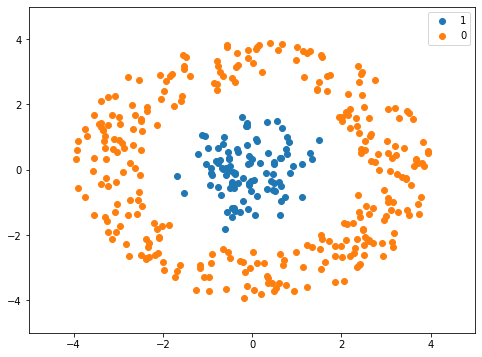

In [3]:
df_train = train_data()

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

c = df_train['y'] == 1
ax.scatter(df_train[c]['x_1'], df_train[c]['x_2'], marker='o', color='C0', label='1')
ax.scatter(df_train[~c]['x_1'], df_train[~c]['x_2'], marker='o', color='C1', label='0')
ax.legend()

plt.show()

The only change to the `NeuralNet` code is that when the weight matrices are
returned we return a deep copy of them.

In [4]:
class Neuron():
    """ a neuron with an activation function and its derivative """
    def __init__(self, sigma, sigma_prime):
        self._sigma = sigma
        self._sigma_prime = sigma_prime
        
    @property
    def sigma(self):
        return self._sigma
    
    @property
    def sigma_prime(self):
        return self._sigma_prime
        
    def __str__(self):
        return "Neuron()"
    
class Layer():
    """ a layer of a neural network. The layer assumes that
    every neuron has the same activation function except
    for potentially a constant neuron at the end. If
    being used as an input layer, sigma_prime can be
    left as None. If has_const==True, then the nth
    neuron will be the constant neuron"""
    
    def __init__(self, n, sigma, sigma_prime=None, has_const=False):
        self._neurons = [Neuron(sigma, sigma_prime) for i in range(n)]
        self._has_const = has_const
        
        if has_const:
            self._neurons[-1] = Neuron(const, const_prime)
        
    def __str__(self):
        return "Layer() of {} neurons".format(self.width)
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def has_const(self):
        return self._has_const
    
    @property
    def width(self):
        return len(self._neurons)
        
    def output(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma(x[i]) for i in range(len(x))])
    
    def output_prime(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma_prime(x[i]) for i in range(len(x))])

class NeuralNet():
    """ a neural net that is constructed from the layers
    it is given. Should be given both an input layer 
    and an output layer. Weights will be initialized
    with the proper shape, but as all ones and zeros. They
    can either be initiated using the function included
    here or set by hand.
    
    With T hidden layers, we have T+2 layers of neurons
    as we have the input and output layers. There are only
    T+1 layers of weights, however, as there are no
    weights from the output layer.
    
    We're going to initialize with Kaiming initializaiton.
    If non-ReLU / ELU is used, set w by hand before training."""
    
    def __init__(self, layer_list, check_w_before_set=True, 
                 init='Xavier', random_seed=None):
        np.random.seed(random_seed)
        
        self._layers = layer_list
        self._checks = check_w_before_set
        
        def get_layer_architecture(l, l_next):
            arch = np.ones(shape=(l_next.width, l.width))
            if l_next.has_const:
                arch[-1,:] = 0
            return arch
            
        self._architecture = [
            get_layer_architecture(self._layers[i], self._layers[i+1])
            for i in range(len(self._layers) - 1)
        ]
        
        def init_weights(i, init):
            """ init weights with either Xavier or Kaiming He initialization 
            If there are biases in this layer, they are initialized to something small"""
            
            if self._layers[i].has_const:
                ncols = self._layers[i].width - 1
            else:
                ncols = self._layers[i].width
                
            if self._layers[i+1].has_const:
                nrows = self._layers[i+1].width - 1
            else:
                nrows = self._layers[i+1].width
                
            mean = 0
            if init == 'Xavier':
                # assumes sigma(a) ~ a for a near zero
                std = np.sqrt(2.0 / (ncols + nrows))
            else:
                # Keiming He init: assumes ReLU
                std = np.sqrt(2.0 / ncols)

            weights = np.random.normal(mean, std, size=(nrows, ncols))
            while abs(np.std(weights)-std) > .05 or abs(np.mean(weights)-mean) > .05:
                weights = np.random.normal(0, std, size=(nrows, ncols))

            w = self._architecture[i].copy() * .1
            w[:nrows, :ncols] = weights
            
            return w

        self._w = [init_weights(i, init) for i in range(len(self._architecture))]
        
    def __str__(self):
        num_hidden = len(self._layers) - 2
        width = np.max([l.width for l in self._layers])
        return "NeuralNet() with {0} hidden layer(s) and width {1}".format(num_hidden, width)
        
    @property
    def layers(self):
        return self._layers
    
    @property
    def architecture(self):
        return self._architecture
        
    @property
    def w(self):
        return copy.deepcopy(self._w)
    
    @property
    def check_w_before_set(self):
        return self._checks
    
    def _check_architecture(self, w, a):
        """checks that w has zeros wherever a does """
        inds = np.where(a==0)
        if len(inds[0]) == 0:
            return True
        else:
            return all([w[inds[0][i], inds[1][i]] == 0 for i in range(len(inds[0]))])
    
    @w.setter
    def w(self, w_val):
        if self._checks:
            # check that w_val has proper sizes
            assert len(w_val) == len(self._w), "proposed w has bad length"
            assert all([w_val[i].shape == self._w[i].shape for i in range(len(self._w))]), \
                "proposed w has bad shapes somewhere"
            assert all([self._check_architecture(w_val[i], self._architecture[i]) for i in range(len(self._w))]), \
                "proposed w has bad architecture"
        self._w = w_val
        
    def copy_weights(self):
        return [w.copy() for w in self._w]
        
    def _clean_x(self, x):
        """ take data of form (n_samples, n_features)
        that is either a pandas DataFrame, list, or numpy array
        and convert to numpy array (if needed) and transpose. """
        if type(x) == np.ndarray:
            return x.transpose()
        elif type(x) == pd.DataFrame:
            return x.copy().values.transpose()
        elif type(x) == list:
            return np.array(x).transpose()
    
    def _clean_y(self, y):
        """ take a column vector and make sure it's a numpy column vector """
        if type(y) == np.ndarray:
            return y.reshape(-1, 1)
        elif type(y) == pd.Series:
            return y.values.reshape(-1, 1)
        elif type(y) == list:
            return np.array(y).reshape(-1, 1)
        
        
    def raw_output(self, x, already_cleaned=True):
        """ gets the raw output of the neural network
        
        x needs to have shape (n_samples, n_features)
        without the constant feature appended."""
        
        if already_cleaned:
            raw_output, _, _ = self._forward_pass(x)
        else:
            raw_output, _, _ = self._forward_pass(self._clean_x(x))
        
        return raw_output
    
    def predict(self, x, already_cleaned=True):
        """ gets the 0 or 1 prediction of the neural network """
        z = self.raw_output(x, already_cleaned)
        return 1 * (z >= 0.5) + 0 * (z < 0.5)
    
    def _forward_pass(self, x):
        """ forward pass through the neural network recording
        the outputs and inputs as we go. As an internal
        function, the input x will already be an numpy array
        with shape (n_features+1, n_smples). The +1 is
        for the constant feature."""
        
        # every layer has an input
        a = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
                
        # every layer has an output
        o = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
        
        a[0] = x
        o[0] = self._layers[0].output(a[0])
        
        for i in range(1, len(self._layers)):
            a[i] = np.matmul(self._w[i-1], o[i-1])
            o[i] = self._layers[i].output(a[i])
        
        raw_output = o[-1].transpose()
        
        return raw_output, a, o
    
    def _backward_pass(self, a, o, y):
        """ backward pass through the neural network
        using the forward pass results to calculate the gradient
        as well as the true values which in this case
        are +1 or -1 only. y should be a row vector of
        these values with the same number of columns
        as a[-1] and o[-1], which should have indenticial shapes.
        
        The output is the average gradient for the samples given."""
        
        num_samples = y.shape[1]
        
        # first calculate the sigma_prime values for each hidden + output layer
        sigma_prime = [None] + \
            [self._layers[i].output_prime(a[i]) for i in range(1, len(self._layers))]
        
        # now we start the backward pass for real
        delta = [None] + [np.zeros(a[i].shape) for i in range(1, len(self._layers))]
        z = o[-1] - y
        delta[-1] = z
        
        for i in range(-2, -len(delta)-1, -1):
            # this is w[i+1] bc len(w) = len(delta) - 1
            delta[i] = np.matmul(self._w[i+1].transpose(), (sigma_prime[i+1]) * delta[i+1])
        
        # calculate the average gradient across all samples
        return [
            np.matmul((sigma_prime[i+1] * delta[i+1]), o[i].transpose()) / num_samples
            for i in range(len(self._w))
        ]
    
    def fit(self, x, y, eta=0.1, max_error=0.1, 
            max_epochs=5, batch_size=100, max_iter=None,
            save_data=False, random_seed=None):
        """ use stochastic gradient descent with backpropagation
        to fit the network to the given training data x which
        should be of size (n_samples, n_features),
        y should be of size (n_samples, 1)"""
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        x_ = self._clean_x(x) # (n_features, n_samples) matrix
        y_ = self._clean_y(y) # column vector
        num_samples = y_.shape[0]
        
        # some samples might be left behind
        batches_per_epoch = np.floor(num_samples / batch_size)
        saved_data = []
        
        w = self.copy_weights()
        
        def calculate_train_error():
            current_predictions = self.predict(x_)
            wrong = np.sum(np.abs(y_ - current_predictions))
            return 1.0 * wrong / num_samples
                    
        curr_iter = 1
        curr_epoch = 1
        curr_batch_number = 0
        batch_indexes = np.arange(num_samples)
        train_error = calculate_train_error()
        
        def get_save_data():
            max_w = np.max([np.max(np.abs(w)) for w in self._w])
            min_w = np.min([np.min(np.abs(w)) for w in self._w])
            current_output = self.raw_output(x_)
            avg_loss = np.mean((current_output - y_)**2)

            return {
                'epoch': curr_epoch
                ,'avg_loss': avg_loss
                ,'train_error': train_error
                ,'max_w': max_w
                ,'min_w': min_w
                ,'w': self.copy_weights()
            }
            
        if save_data:
            saved_data = [get_save_data()]  
            
        keep_training = True   
        while keep_training:
            
            if curr_batch_number == 0:
                # re-shuffle indexes as neded
                logging.debug("NeuralNet.fit(): starting epoch {}".format(curr_epoch))
                np.random.shuffle(batch_indexes)
                
            batch_ind = batch_indexes[curr_batch_number * batch_size:(curr_batch_number + 1) * batch_size]
            
            x_batch = x_[:, batch_ind]
            y_batch = y_[batch_ind,:]
            
            # forward pass
            _, a, o = self._forward_pass(x_batch)
            
            # backward pass
            grad = self._backward_pass(a, o, y_batch.transpose())
            
            w = [w[i] - eta * grad[i] for i in range(len(w))]
            self.w = [
                (curr_iter * self._w[i] + w[i]) / (curr_iter + 1)
                for i in range(len(self._w))
            ]
            
            train_error = calculate_train_error()
            curr_iter += 1
            curr_batch_number = int((curr_batch_number + 1) % batches_per_epoch)
            
            if curr_batch_number == 0:
                curr_epoch += 1
                
                if save_data:
                    saved_data += [get_save_data()]
                    
            keep_training = train_error >= max_error and curr_epoch <= max_epochs
            if max_iter is not None:
                keep_training = keep_training and curr_iter <= max_iter
            
            
        if curr_epoch > max_epochs:
            logging.warning("NeuralNet.fit():no convergence, train_error above max_error")
        else:
            pass
            #logging.warning("NeuralNet.fit(): converged during epoch {}.".format(curr_epoch-1))
        
        if save_data:
            return saved_data
        else:
            return None


In [5]:
def relu(x):
    return x * (x>0) + 0 * (x<=0)

def relu_prime(x):
    return 1 * (x>0) + 0 * (x<=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def const(x):
    if type(x) == np.ndarray:
        return np.ones(x.shape)
    elif type(x) == list:
        return np.ones(len(x))
    else:
        return 1
    
def const_prime(x):
    if type(x) == np.ndarray:
        return np.zeros(x.shape)
    elif type(x) == list:
        return np.zeros(len(x))
    else:
        return 0    

In [6]:
class ReLUNet(NeuralNet):
    """ Simpler neural net in that we require all
    hidden layers to use the same activation function
    and the output to be a single sigmoid activator. 
    The input must also be two-dimensional. """
    
    def __init__(self, hidden_layer_widths, random_seed=47):
        
        layer_list = [Layer(3, lambda x: x, None, True)]
        layer_list += [
            Layer(n, relu, relu_prime, True)
            for n in hidden_layer_widths
        ]
        layer_list += [Layer(1, sigmoid, sigmoid_prime, False)]
        
        super().__init__(layer_list, init='He', random_seed=random_seed)

## Coefficient distribution changes

Here we take a look at how the distribution of coefficients changes during training. We initialized
with the assumption that the coeicients would maintain mean zero as well as not increase their
variance as a way to avoid gradient blowup and vanishing. It's possible however that the
distribution changes in some significant way while maintaining these two properties.

To test this, we'll train the same architecture 10 times using a different random seed.
We'll record the initial weights and final weights for each training session. 
Extracting all weights, we see if the distributions change using a Kruskal-Wallis test.

In [7]:
# These are helper functions that can mostly be ignored.

def get_biases_layer(weights):
    """ take in weights for a single layer and return the
    biases. """
    if weights.shape[0] == 1:
        return np.array([weights[0, -1]])
    else:
        return weights[:-1, -1]
    
def get_biases(weights_list):
    """ take in list of weights and biases and return biases.
    This assumes that every layer has biases except the output
    layer."""
    return np.concatenate([get_biases_layer(w) for w in weights_list])

def get_weights_layer(weights):
    """ take in weights for a single layer and return them
    without biases. """
    if weights.shape[0] == 1:
        return weights[0, :-1]
    else:
        return weights[:-1, :-1]

def get_weights(weights_list):
    """ take in list of weights and biases and return weights.
    We ignore weights that are zero and would feed into the bias
    neurons. This assumes that every layer has biases except the
    output layer."""
    return np.concatenate([get_weights_layer(w).ravel() for w in weights_list])

def get_weights_nonvec(weights_list):
    """ same as get_weights, but not vectorized """
    return [get_weights_layer(w) for w in weights_list]

Change in mean: 0.0121
Change in standard deviation: 0.0216
Kruskal-Wallis p-value that final and initial weights have different distributions: 0.4291


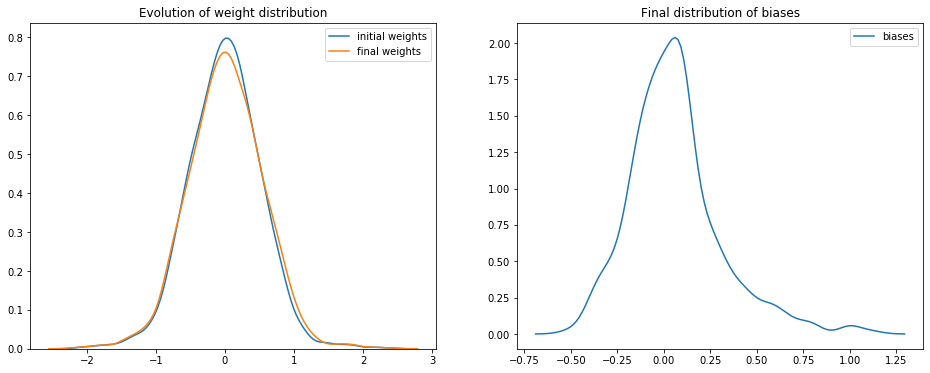

In [8]:
# In this cell we train the architecture multiple times 

from scipy.stats.mstats import kruskalwallis

features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

initial_weights = np.array([])
final_weights = np.array([])
final_biases = np.array([])

for i in range(10):
    nn = ReLUNet([10, 10, 10, 10], random_seed=i)
    data = nn.fit(**train_params)
    
    initial_weights = np.concatenate([initial_weights, get_weights(data[0]['w'])])
    final_weights = np.concatenate([final_weights, get_weights(data[-1]['w'])])
    final_biases = np.concatenate([final_biases, get_biases(data[-1]['w'])])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(initial_weights, hist=False, label="initial weights", ax=ax[0])
sns.distplot(final_weights, hist=False, label="final weights", ax=ax[0])
ax[0].set_title('Evolution of weight distribution')

sns.distplot(final_biases, hist=False, label="biases", ax=ax[1])
ax[1].set_title('Final distribution of biases')

plt.plot()

mean_change = np.mean(final_weights) - np.mean(initial_weights)
std_change = np.std(final_weights) - np.std(initial_weights)
pval = kruskalwallis(initial_weights, final_weights).pvalue

print("Change in mean: {:.4f}".format(mean_change))
print("Change in standard deviation: {:.4f}".format(std_change))
print("Kruskal-Wallis p-value that final and initial weights have different distributions: {:.4f}".format(pval))

There appears to be some small spread away from the mean during training, but overall there is not much change.
The biases, which are initially all 0.1, do change somewhat more, but even then are mostly concentrated
around their initial values. The p-value for the non-bias weights is very large, indicating there is no
significant change.

## Coefficient directions

Another question I have is how do individual coefficients move? Do they start moving one direction
and move that way forever, or do they bounce around, getting larger and smaller as training goes?
Here I'll train a neural net with a decent amount of hidden layer neurons and keep track of
how those neurons are changing.

In [9]:
# train a neural net
features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

nn = ReLUNet([10, 10, 10, 10], random_seed=1)
data = nn.fit(**train_params)

In [10]:
# pull out weights at every step and look for changes in direction
weights = np.hstack([get_weights(d['w']).reshape(-1, 1) for d in data])
deltas = np.hstack([(weights[:, i] - weights[:, i-1]).reshape(-1, 1) 
                   for i in range(1, weights.shape[1])])
sign_deltas = 1 * (deltas > 0) - 1 * (deltas < 0) + 0 * (deltas == 0)
direction_changes = np.hstack([(sign_deltas[:, i] - sign_deltas[:, i-1]).reshape(-1, 1) 
                               for i in range(1, sign_deltas.shape[1])])
has_change = 1 * (direction_changes != 0) + 0 * (direction_changes == 0)

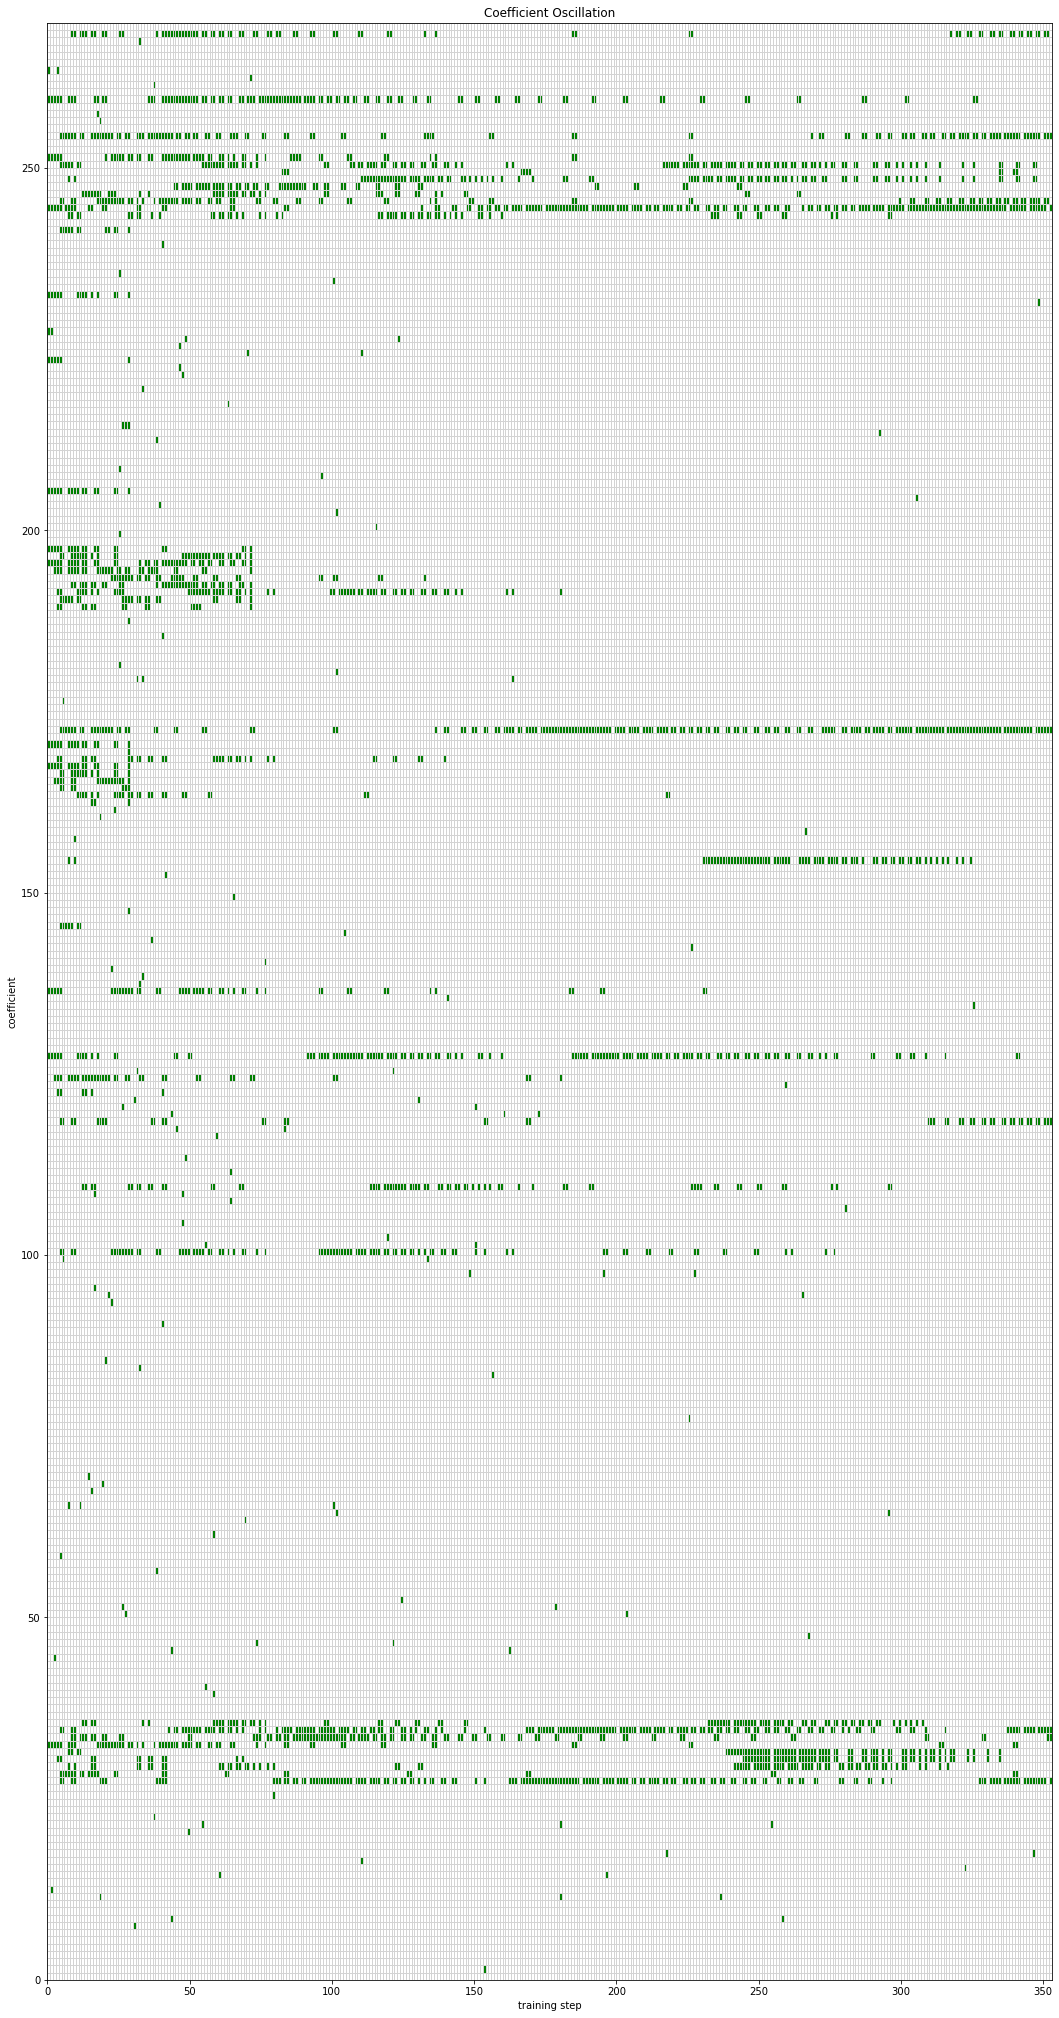

In [11]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(18, 36))

ax.set_ylim([0, 270])
ax.set_xlim([0, len(data)-2])
ax.set_xlabel('training step')
ax.set_ylabel('coefficient')

white_rects = []
green_rects = []

for i in range(has_change.shape[0]):
    for j in range(has_change.shape[1]):
        rect = Rectangle((j, i), 1, 1)
        if has_change[i, j] == 0:
            white_rects.append(rect)
        else:
            green_rects.append(rect)
        
ax.add_collection(PatchCollection(white_rects, facecolor='white',  edgecolor='lightgrey'))
ax.add_collection(PatchCollection(green_rects, facecolor='green',  edgecolor='lightgrey'))
ax.set_title('Coefficient Oscillation')

plt.show()

In the above plot, the $x$-axis is the training step or epoch while the each unit on the $y$-axis
is a coefficient in a weight matrix (excluding biases). A square is present if in that
training epoch the coefficient changed the direction it was moving, either it was going in the
positive direction between the previous two epochs and now was going in the negative direction
or vice versa. The higher on the $y$-axis, the closer to the output layer. There are four 
equally sized hidden layers here, so the weight matrices save the one going to the output
layer are the same size.

Alternatively, I will also rank neurons by the absolute value of their largest coefficient.
This would correspond to pruning neurons starting from those which have the smallest
largest weight feeding into them. Obviously there are more ways to rank neurons than just
by average percentile (which might be a weird way to do it anyway!) and maximum value.

Although I'm only including one plot, this seems to be the typical behavior. Most coefficients
don't really change direction too much, some oscillate a lot early on before setting down,
and a few oscillate most of the time. I should probably shade this relative to magnitude
so we can see if the highly oscillatory coefficients are small or not.

## Neuron importance

Not having read yet about pruning neural networks (next post?), I'm going to try to 
do a more compact visualization that focuses on the neurons and not just the weights.
I'm going to rank neurons in terms of importance in one of the three following ways.

1. Rank the neurons by the mean of the absolute values of the weights that feed
into it. That is, take the mean of the absolute values of each row of the weight
matrix feeding into the layer.
2. Rank the neurons by the mean of percentiles of the absolute values that feed into
it. This considers only the order of the magnitudes of the weights.
3. Rank the neurons by the largest absolute value of the weights that feed into it.

Each of these methods can be thought of as different methods of pruning the neurons.
Perhaps a pruning method should also take into account the weights from the neuron
or perhaps we should take into account the distribution of the data feeding into the
neuron. These more complicated ideas I may or may not explore later as I read more
about pruning neural nets.

Similar to the plots above, we will plot changes to neuron importance over time. This time
with two colors, green for a neuron that has gained importance and red for a neruon that
has lost importance. We'll need a lot of functions first, so feel free to skip over them.

In [12]:
class BadMethodException(Exception):
    def __init__(self):
        super().__init__("method must be 'mean', 'mean-percent', or 'max'")

def get_percentiles(w):
    """ replace each value in a numpy array with the
    percentile of its absolute value """

    w_abs = np.abs(w)
    sort_flat = np.sort(w_abs.flatten())
    n = len(sort_flat)
    percentiles = {sort_flat[i]: 100.0 * i / n  for i in range(n)}
    
    w_percentiles = np.zeros(shape=w.shape)

    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            w_percentiles[i, j] = percentiles[w_abs[i, j]]
            
    return w_percentiles

def order_neurons_by_input(w_perc, method='mean'):
    """ take a weight matrix with percentiles and give
    scores 0 to n_t-1 based on the average percentile for
    the weights feeding into the neuron """
    
    def get_keys(w_row):
        if method=='mean' or method == 'mean-percent':
            return (w_row.mean(), w_row.max(), np.random.random())
        if method=='max':
            return (w_row.max(), np.random.random())
        else:
            raise BadMethodException
    
    w_perc_sorted = sorted(w_perc, key=get_keys)
    n = len(w_perc_sorted)
    w_dict = {tuple(w_perc_sorted[i]): i for i in range(n)}
    
    return [w_dict[tuple(ww)] for ww in w_perc]

def get_neuron_orders(w, method='mean'):
    """ get neuron orders for a given weight matrix """
    try:
        _ = w.shape[1]
    except IndexError:
        w = w.reshape(1, -1)
    
    if method == 'mean' or method == 'max':
        return order_neurons_by_input(np.abs(w), method)
    elif method == 'mean-percent':
        return order_neurons_by_input(get_percentiles(np.abs(w)), method)
    else:
        raise BadMethodException()

def get_all_neuron_orders(weights, method='mean'):
    return [get_neuron_orders(w, method) for w in get_weights_nonvec(weights)][:-1]

def add_lists_of_lists(k1, x, k2, y):
    """ k1 * x + k2 * y for lists of lists x and y.
    assumes the lists in x and y have matching lengths """
    z = copy.deepcopy(x)
    
    for i in range(len(x)):
        z[i] = list(k1 * np.array(x[i]) + k2 * np.array(y[i]))
        
    return z
        

In [13]:
def plot_mean_neuron_changes(w_list, ax, method='mean'):
    """ take a list of weights (which are lists of numpy arrays)
    and plot blocks representing the changes in neuron order
    during training.
    
    Neuron order is determined as follows: figure out the
    percentiles of each weight feeding into a neuron relative
    to all the weights in the given layer. Neurons are then
    ordered by the average percentile of the weights feeding
    into it. Is this valid, not sure!
    """
    neuron_orders = [get_all_neuron_orders(w, method) for w in w_list]
    order_changes = [add_lists_of_lists(1, neuron_orders[i], -1, neuron_orders[i-1]) for i in range(1, len(neuron_orders))]

    total_neurons = 0
    for i in range(len(order_changes[0])):
        for j in range(len(order_changes[0][i])):
            total_neurons += 1
    total_layers = len(order_changes[0])

    ax.set_ylim([-1, total_neurons + total_layers])
    ax.set_xlim([0, len(order_changes)])
    ax.set_xlabel('training step')
    ax.set_ylabel('coefficient change')
    ax.set_yticks([])

    green_rects = []
    red_rects = []
    white_rects = []

    for k in range(len(order_changes)):
        total_j = 0
        for i in range(len(order_changes[k])):
            for j in range(len(order_changes[k][i])):

                rect = Rectangle((k, i + total_j), 1, 1)
                total_j += 1

                if order_changes[k][i][j] > 0:
                    green_rects.append(rect)
                elif order_changes[k][i][j] < 0:
                    red_rects.append(rect)
                else:
                    white_rects.append(rect)

    ax.add_collection(PatchCollection(white_rects, facecolor='white',  edgecolor='lightgrey'))
    ax.add_collection(PatchCollection(green_rects, facecolor='green',  edgecolor='lightgrey'))
    ax.add_collection(PatchCollection(red_rects, facecolor='red',  edgecolor='lightgrey'))
    
    if method == "mean":
        ax.set_title('Changes in neuron rank by layer: mean weight rank')
    elif method == "max":
        ax.set_title("Changes in neuron rank by layer: max weight rank")
    elif method == "mean-percent":
        ax.set_title("Changes in neuron rank by layer: mean percentile rank")
    else:
        raise BadMethodException
    
    return ax

We'll start by posting the change in neuron rank plots for the same neural net 
we trained above with four hidden layers each having 9 neurons and a bias, although
our rankings do not take into account the biases. Similarly to before, each row
corresponds to a different neuron and there are gaps between each layer. Closer to
the top means closer to the output layer.

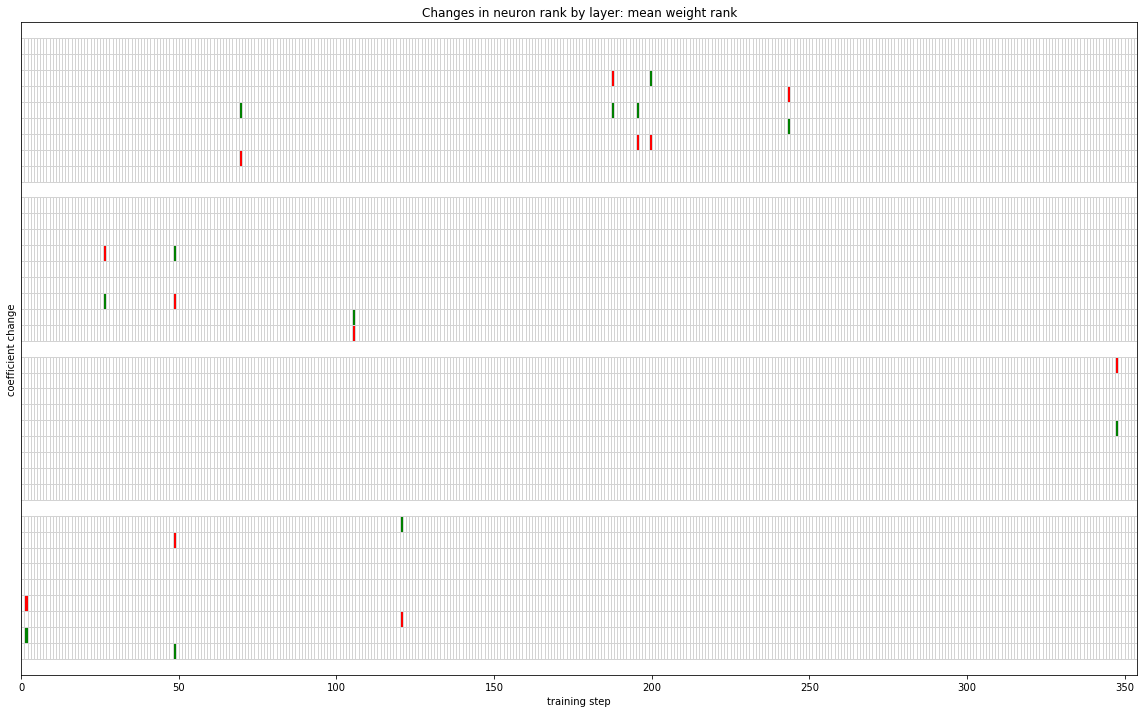

In [14]:
# train
nn_ = ReLUNet([10, 10, 10, 10], random_seed=1)
data_ = nn_.fit(**train_params)

# plot
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data_], ax, method='mean')
plt.show()

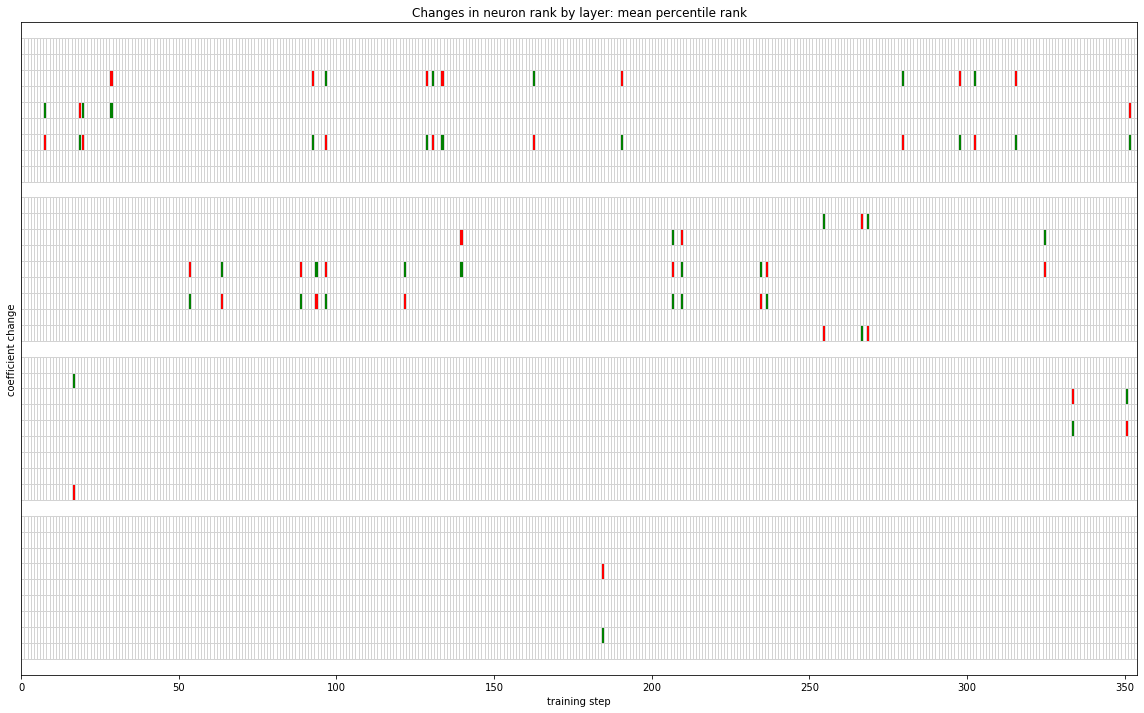

In [15]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data], ax, method='mean-percent')
plt.show()

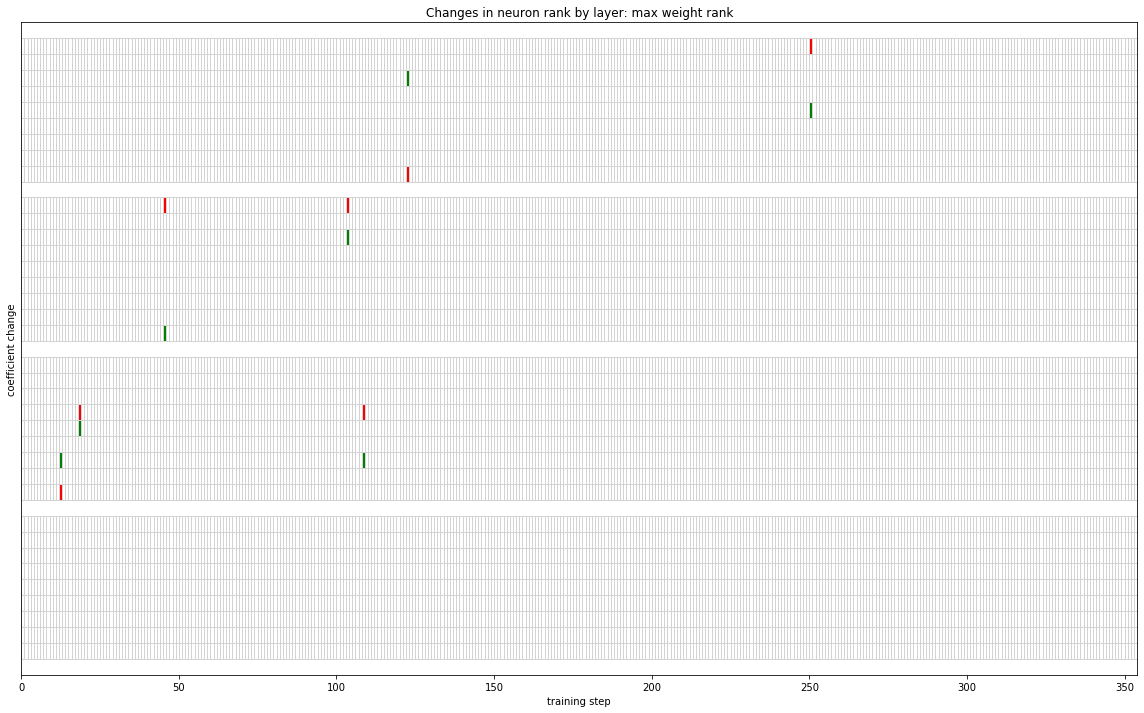

In [16]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data], ax, method='max')
plt.show()

We now make the same three plots for a neural net with the same architecture, 
but we change the initialization to show some variation in training patterns
depending on the initial structure.

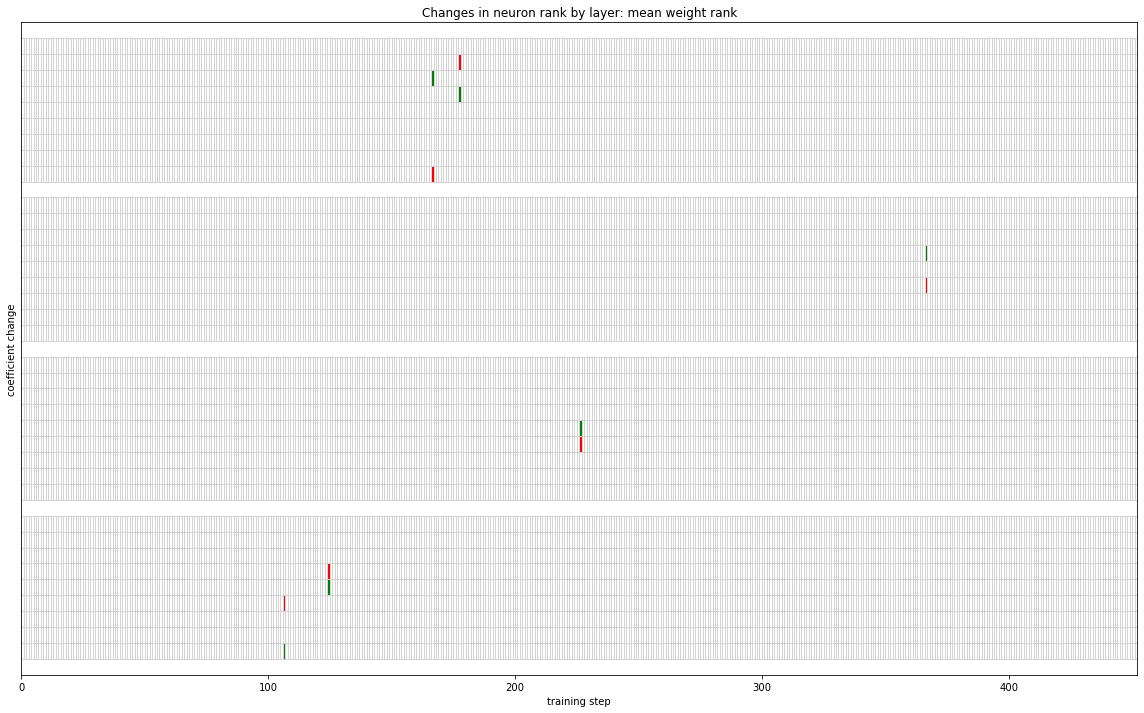

In [17]:
# plot
nn_ = ReLUNet([10, 10, 10, 10], random_seed=10)
data_ = nn_.fit(**train_params)

# train
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data_], ax)
plt.show()

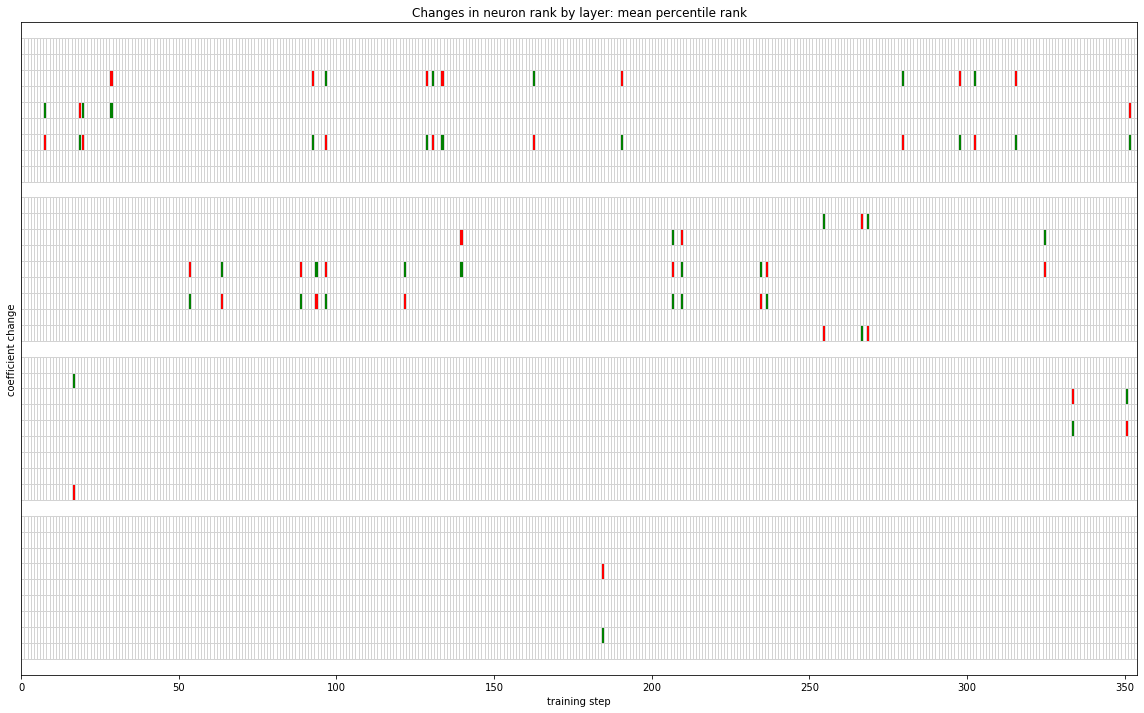

In [18]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data], ax, method='mean-percent')
plt.show()

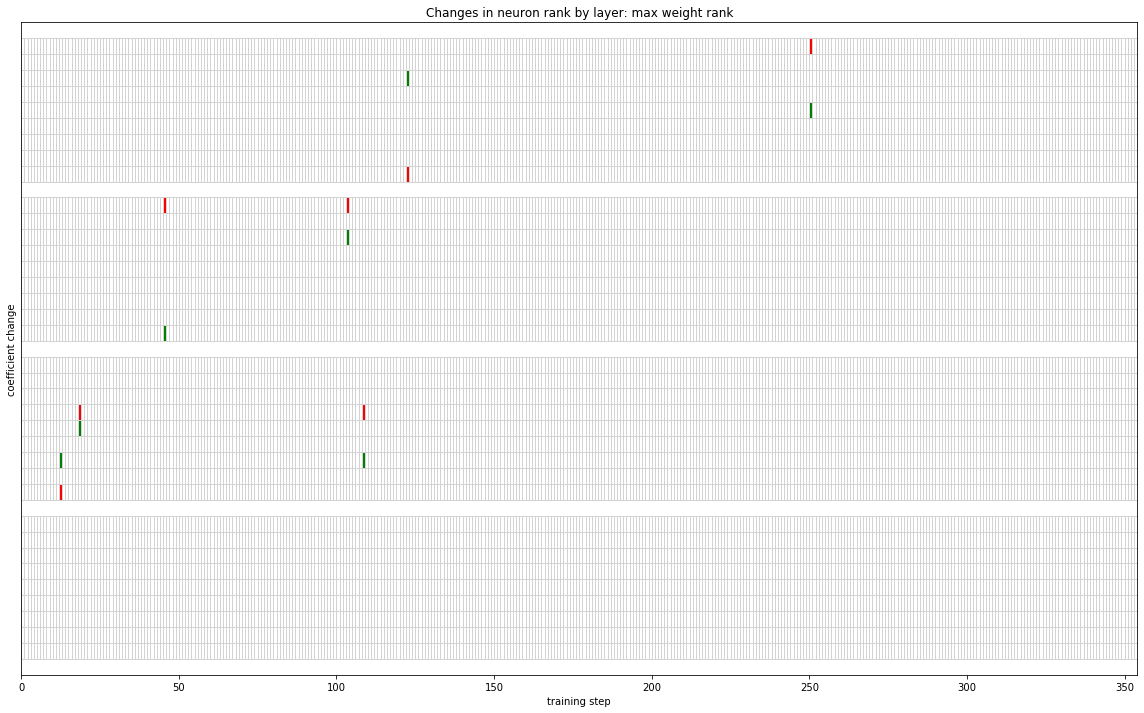

In [19]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data], ax, method='max')
plt.show()

Below we show the training that occurs for a shallower and skinnier neural net trying to train on the
same problem. Here the random seed was more carefully chosen, as training does not always converge within
2000 epochs, i.e., this architecture is not as robust, probably because it must start out closer to a
solution to converge, while the larger neural nets have more options.

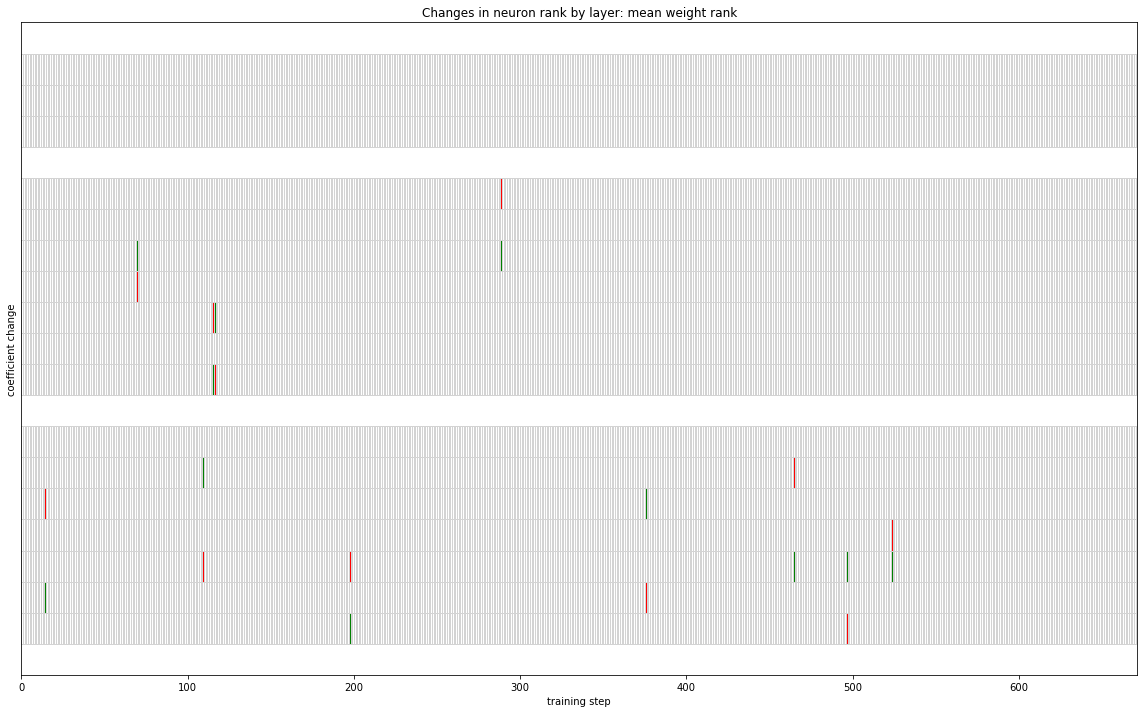

In [20]:
# train
nn_ = ReLUNet([8, 8, 4], random_seed=13)
data_ = nn_.fit(**train_params)

# plot
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data_], ax)
plt.show()

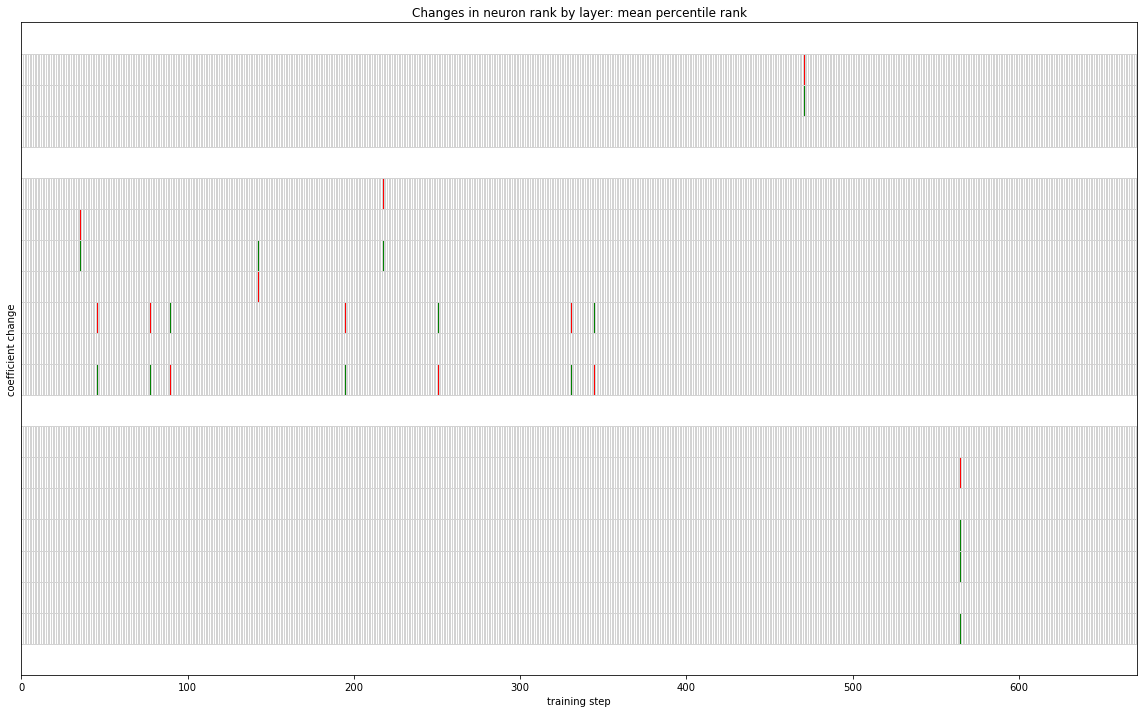

In [21]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data_], ax, method='mean-percent')
plt.show()

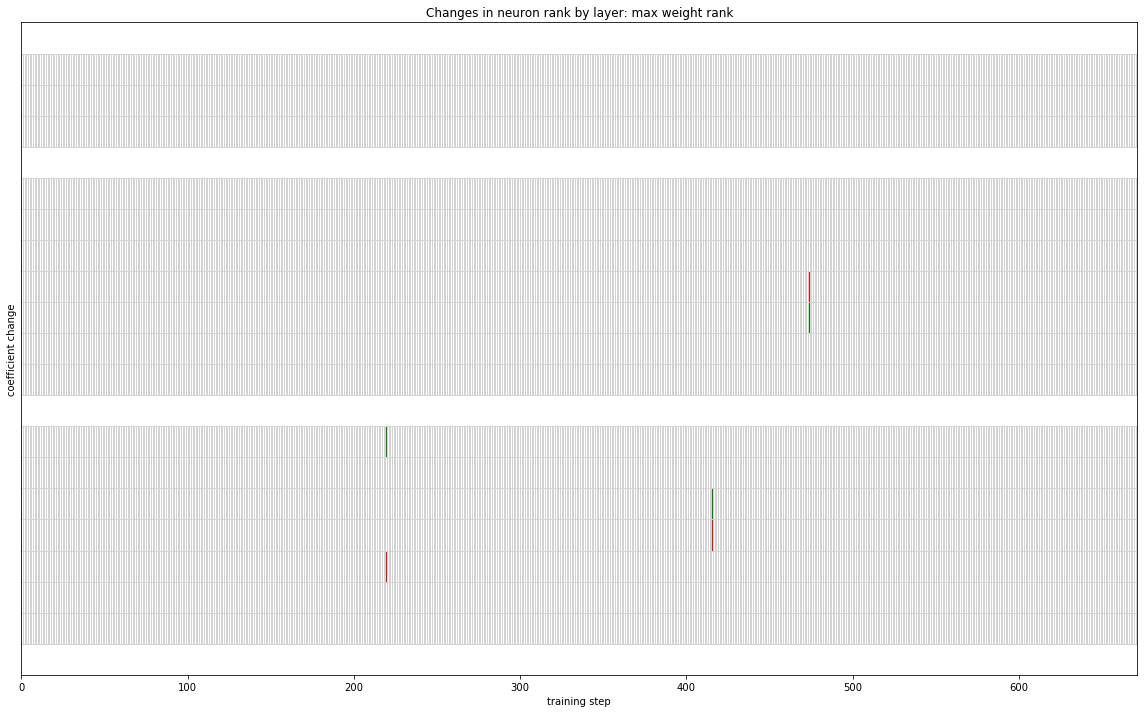

In [22]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = plot_mean_neuron_changes([d['w'] for d in data_], ax, method='max')
plt.show()

While I think this gives a general idea about training, it was not very scientific.
It looks like changes are more prevalent the closer you are to the output layer
which I've heard talk about, but not verified hear nor read the relevant literature.

## Distance between neural nets

Now the question that I'm more interested in is whether neural nets
with idential architectures converge to the same solution or
whether they converge to different solutions. This necessitates
thinking about some sort of distance between neural networks.

Surely this has been thought about elsewhere, but before I go looking,
let's write up some thoughts about how to calculate the distance
between different neural networks in some metric space that we'll
describe below. We will start with the types of neural networks
that we have been consdering above: single ouput neural networks
where all non-constant neurons have the same activation function.

I'll talk about generalizing a little bit, but it's hard to say which
generalizations would be useful, and which would not be.

### Same architecture

To start, let's consider neural networks $N\_1$ and $N\_2$ which have
the same architecture: same output activation function, same input
dimensions, same number of layers, and same number of neurons in
each layer with the same (identical in this case) activation functions
for each neuron, and each layer correspondingly does or does not 
have bias neurons (i.e., a neuron which just puts out 1 and does not
take input). 

Let the layer $V\_{t, i}$ consist of the neurons 
$\{v\_{t, i}^1, \ldots, v\_{t, i}^{n\_t}\}$
each with the same activation function, as well as possibly having
a bias neuron $v^{n\_t+1}\_{t, i}$ which takes no input and always has 1
as its output. Let $W^{t, i}$ be the weight matrix from $V\_{t, i}$ 
to $V\_{t+1, i}$ for network $N\_i$. We make an identification
between neurons and weights in the natural way, i.e., the output of
$v^j\_{t, i}$ is weighted according to column $j$ of $W^{t, i}$
and the input of $v^k\_{t+1, i}$ is weighted according to row $k$
in $W^{t, i}$. 

A first attempt at defining the distance between $N_1$ and $N_2$
would be to embed all the weights into vectors then take say the
Euclidean distance between these two vectors.

#### Neuron permutations

However, note that element-wise the $W^{t, i}$ might be
distinct, but the outputs of the neural networks could be identical.
One way this is possible, is if the neurons in a given layer have been
re-ordered in some way. In other words, maybe all the weights
would be identical if we switched $v^1\_{t, 2}$ and $v^2\_{t, 2}$.
In terms of $W^{t, 2}$, this would mean switching column 1 and
column 2. We also need to simultaneously switch rows 1 and 2 of $W^{t-1, 2}$.
Note that we are only switching non-bias neurons in hidden layers
and two transformations will also have to happen.

If $W^{t, i}$ is an $n\_{t+1}\times n\_t$ matrix, then this
means multiplying on the right by an $n\_t \times n\_t$ matrix
which looks like the identity matrix except rows 1 and 2 have been
swapped. We multiply $W^{t-1, i}$ by the same matrix, but on the
left instead. More generally, we can replace the special matrix
above with any permutation matrix, that is, a square matrix with
a exactly a single 1 in each row and column. If $V^{t, i}$
has a bias neuron, we do not allow it to be permuted, instead
taking

Since these transformations do not change the output at all,
we should change the distance to be invariant under them.
We can do this by taking the distance to be the minimum distance
between the weight vectors allowing for these permutations.

#### Scaling the output

If we only want to consider raw output, we should probably stop
with the above. But if we are considering 0-1 classification with
the output neuron having a sigmoid activation function, we
probably should not, since $N_1$ and $N_2$ will agree on the classification
if we scale the input to the output neuron by a positive constant. 
In other words, we scale $W^{T, i}$ (which is just a row vector) 
by a positive constant.

Should we allos invariance under these things? I think no. First off,
if we are doing regression this will not be desirable. Second off,
given that we are mostly considering $\operatorname{ReLU}$ activations,
we could achieve the same affect by mutliplying $W^{T-1, i}$ by
the same positive constant, as this would scale. But then this means
we could do the same thing by multiplying $W^{T-2, i}$ by that
same constant instead! And so on and so forth. However, not only 
is this not possible in the general case (although maybe multiplying
by some other scaled version of the constant would work), we would be
changing the distribution of the coeffciients which we meticulously 
set. So we will not make our distance function invariant under any
sort of scaling, just permutation.

### Different architectures

As long as the activation functions are the same, you can pad out
shorter layers with neurons that always have zero input and zero
output until the architectures match. Basically, everything lives
in a space with infinitely many neurons at every layer with only
finitely many of the neurons nonzero.

I don't know that there is much that can be done if the activation
functions are different in a given layer. If there are matching
activation functions in each layer you could pair them off, but
this seems like a rare case.

### Implementation

I am not sure the best way to implement these distances. I think 
one way to go that won't necessarily guarantee you the true distance as
defined above would be to move layer by layer. The issue is that shifting
neurons in one layer affects two weight matrices simultaneously.
So perhaps you stop shifting when only the input weights to that layer
are closest. You could also stop when the distance is lowered overall 
which takes into account both input and output weight matrices, but
the output weight matrix will again be shifted when the next layer 
is perturbed. The drawback of the first method is that the final
layer of weight matrices are never directly compared. Neither of
these methods guarantees you find the true distance between the
neural nets.

For a given layer, I'm going to brute force it and check all possible
row combinations. Since my layers are not very wide (max of like 10)
this shouldn't take too long even for half a dozen layers.

I think that if the neural nets are identical save for neuron order
that we will get zero as the distance using this algorithm.

Aside: is there a way that architecturally identical neural networks
can have exactly the same decision boundary with distinct weights?
Possibly.

#### Implementation code

Here is some code to both calculate the distance between numpy arrays and also 
get permutations in a way that doesn't require storing all of them, i.e., we 
have a mapping from the integers $\{0, 1, \ldots, `n!-1\}$ to all permutations 
of the first $n$ integers.

In [23]:
def matrix_dist(x, y):
    """ calculate ell^2 distance between x and y
    which are numpy arrays with the same shape """
    
    return np.mean(np.sqrt((x - y)*(x - y)))

def permute(n, k):
    """ get permutation on n elements where
    k between 1 and n! parametrizes the permutations """
    x = list(np.arange(n))
    p = []
    while len(x) > 0:
        ell = len(x)
        p += [x.pop(k % ell)]
        k = int((k - (k % ell)) / ell)

    return p

def factorial(n):
    return np.prod(np.arange(n)+1)

Using these functions, we reorder the weights at the first layer in every
possible combination (slow for wide layers!) and finding the optimal order
and making the corresponding re-ordering of the second layer. Then
moving on to the second layer and so on.

In [24]:
def reorder_neural_net_weights(nn_1, nn_2):
    """ returns the weights of nn_2 re-ordered to match those of nn_1 
    as closely as possible. This takes into account the fact that the 
    bottom row may or may not always be zero depending on the
    existence of biases. Hence we are passing in neural networks,
    not just lists of weight matrices."""
    w_1 = nn_1.w
    w_2 = nn_2.w
    
    # re-arrange one hidden layer at a time
    for i in np.arange(1, len(nn_1.layers)-1):
        has_const = nn_1.layers[i].has_const
        
        if has_const:
            num_neurons = nn_1.layers[i].width - 1
        else:
            num_neurons = nn_1.layers[i].width
    
        min_dist = np.Infinity
        min_row_order = None

        for j in range(factorial(num_neurons)):

            if has_const:
                row_order = permute(num_neurons, j) + [num_neurons]
            else:
                row_order = permute(num_neurons, j)

            dist = matrix_dist(w_1[i-1], w_2[i-1][row_order])

            if dist < min_dist:
                min_dist = dist
                min_row_order = row_order

        w_2[i-1] = w_2[i-1][min_row_order].copy()
        w_2[i] = w_2[i][:, min_row_order].copy()
        
    return w_2
    

def approx_neural_net_dist(nn_1, nn_2, distance_func=matrix_dist, reorder_needed=True):
    """ approximates the distance between the neural nets
    assuming that they have the same architecture 
    
    Can replace the distance function with anything
    that acts pairwise on 1-D numpy arrays. """
    # these are deep copies now
    
    if reorder_needed:
        w_2_new = reorder_neural_net_weights(nn_1, nn_2)
    else:
        w_2_new = nn_2.w
        
    w_1_flat = np.concatenate([ww.flatten() for ww in nn_1.w])
    w_2_flat = np.concatenate([ww.flatten() for ww in w_2_new])
    
    return distance_func(w_1_flat, w_2_flat)

Let's establish that if the neural nets have identical initializations
then they have zero distance under this approximate distance.

In [25]:
nn_1 = ReLUNet([8, 8, 4], random_seed=2)
nn_2 = ReLUNet([8, 8, 4], random_seed=2)

print("distance between identical neural nets:", approx_neural_net_dist(nn_1, nn_2))

distance between identical neural nets: 0.0


The same is true if we re-order the weights in the neural net, as desired.

In [26]:
def add_weights(k_1, w_1, k_2, w_2):
    """ add two sets of weights together given same shapes and weights
    multiplied by constants k_1 and k_2"""
    return [k_1 * w_1[i] + k_2 * w_2[i] for i in range(len(w_1))]

def is_reorder_needed(nn_1, nn_2):
    """ given neural nets nn_1 and nn_2 with the same architecture,
    do the weights of nn_2 reorder when calculating the
    distance between the two neural nets? """
    
    w_2_orig = nn_2.w
    w_2_new = reorder_neural_net_weights(nn_1, nn_2)
    
    w_2_delta = add_weights(1, w_2_new, -1, w_2_orig)
    w_2_delta_flat = np.concatenate([w.flatten() for w in w_2_delta]).flatten()
    
    return max(np.abs(w_2_delta_flat)) != 0

In [27]:
nn_1 = ReLUNet([8, 8, 4], random_seed=2)
nn_2 = ReLUNet([8, 8, 4], random_seed=2)

w = nn_1.w

w[0] = w[0][[0, 1, 3, 2, 4, 5, 6, 7]]
w[1] = w[1][[1, 2, 4, 6, 5, 0, 3, 7]]

print("is re-ordering needed? Should be False:", is_reorder_needed(nn_1, nn_2))
nn_2.w = w
print("is re-ordering needed? should be True:", is_reorder_needed(nn_1, nn_2))

is re-ordering needed? Should be False: False
is re-ordering needed? should be True: True


### Where to neural nets converge?

The main thing I want to check is whether two neural nets with identical architecture
trained on the same data but with different initializations converge to the same 
solution. So let's test this!

In [28]:
features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

nn_1 = ReLUNet([8, 8, 4], random_seed=3)
nn_2 = ReLUNet([8, 8, 4], random_seed=13)

print("initial distance:", approx_neural_net_dist(nn_1, nn_2))

data_1 = nn_1.fit(**train_params)
data_2 = nn_2.fit(**train_params)

print("final distance:", approx_neural_net_dist(nn_1, nn_2))

initial distance: 0.3889833843193073
final distance: 0.441161899184026


I'm not sure we can trust that the distance between the two neural nets 
increased, but we can definitely say they did not converge to the
same point. Repeated trainings would show the same thing. Perhaps more
interesting to note is that throughout the course of training, there was
no need to re-order neurons!

In [29]:
nn_initial = copy.deepcopy(nn_1)
nn_initial.w = data_1[0]['w']
nn_final = copy.deepcopy(nn_1)
print("Is reorder needed between initial and final weights?", is_reorder_needed(nn_initial, nn_final))

Is reorder needed between initial and final weights? False


This cannot be guaranteed though, as it should be possible to find a scenario where
re-ordering is necessary, but I have been unable to force it. We do know from the above
examination of the coefficients that the coefficients do wobble around and the relative
sizes of weights going into neurons does flip, but apparently not in a huge way.
This could help explain a bit why pruning and retraining from scratch works, which is
a claim.

Recall that in the version of gradient descent that we're using we don't actually
update the neural network's weights directly by moving them from point to point.
We start a second sequence with the original weights and move that sequence based on 
the gradient. At each step, the neural network's weights are the average of these
"raw weights".

Below here, we look at the distance between the original neural network's weights
and these raw weights as well as the distance between each consecutive step of
raw weights.

In [30]:
features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

nn_1 = ReLUNet([8, 8, 4], random_seed=3)
data_1 = nn_1.fit(**train_params)

raw_weights = [data_1[0]['w']]
for i in np.arange(1, len(data_1)):
    raw_weights += [add_weights((i+1), data_1[i]['w'], -i, data_1[i-1]['w'])]

In [31]:
nn_0_ = copy.deepcopy(nn_1)
nn_1_ = copy.deepcopy(nn_1)

nn_0_.w = raw_weights[0]
dist_from_original = []
for i in np.arange(1, len(data_1)):
    nn_1_.w = raw_weights[i]
    dist_from_original += [approx_neural_net_dist(nn_0_, nn_1_)]

In [32]:
nn_0_ = copy.deepcopy(nn_1)
nn_1_ = copy.deepcopy(nn_1)

dist_consecutive = []
for i in np.arange(1, len(data_1)):
    nn_0_.w = raw_weights[i-1]
    nn_1_.w = raw_weights[i]
    dist_consecutive += [approx_neural_net_dist(nn_0_, nn_1_)]

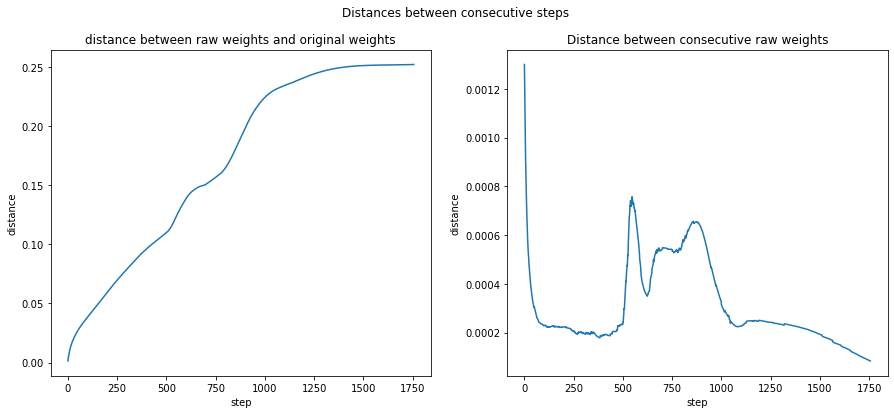

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(np.arange(1, len(data_1)), dist_from_original)
ax[0].set_title('distance between raw weights and original weights')
ax[0].set_xlabel('step')
ax[0].set_ylabel('distance')

ax[1].plot(np.arange(1, len(data_1)), dist_consecutive)
ax[1].set_title('Distance between consecutive raw weights')
ax[1].set_xlabel('step')
ax[1].set_ylabel('distance')

fig.suptitle('Distances between consecutive steps')

plt.show()

You can see how this mirrors training at large, as initially there
are large leaps in distance between consecutive steps in the 
raw weights, but that the consecutive weights settle down to nearly
constant steps as a solution is honed in on.

Finally, let's consider the cosine similarity between the initial
configuration and the both the raw weights and the updated neural
network weights.

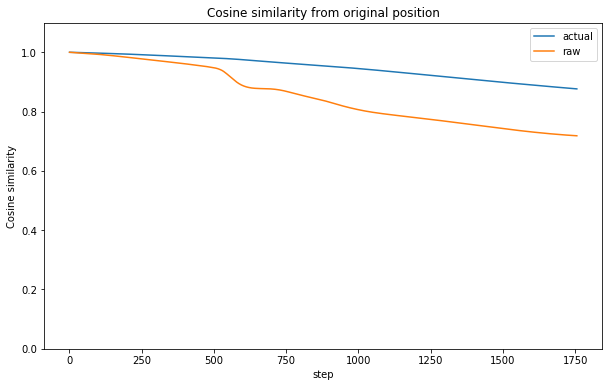

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

w_1_vec = np.concatenate([w.flatten() for w in raw_weights[0]]).reshape(1, -1)
cosangles = []
cosangles_raw = []
for i in np.arange(1, len(data_1)):
    
    w_2_vec = np.concatenate([w.flatten() for w in data_1[i]['w']]).reshape(1, -1)
    w_2_vec_raw = np.concatenate([w.flatten() for w in raw_weights[i]]).reshape(1, -1)
    cosangles += [cosine_similarity(w_1_vec, w_2_vec)]
    cosangles_raw += [cosine_similarity(w_1_vec, w_2_vec_raw)]
    
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(list(np.arange(1, len(data_1))), np.array(cosangles).flatten(), label='actual')
ax.plot(list(np.arange(1, len(data_1))), np.array(cosangles_raw).flatten(), label='raw')
ax.set_ylim([0, 1.1])
ax.set_title('Cosine similarity from original position')
ax.set_ylabel('Cosine similarity')
ax.set_xlabel('step')
ax.legend()

plt.show()

And now let's run the same code with the larger neural net initialized
as when we were examining coefficients and neuron rankings. This takes 
a good while to run, and since the reordering is not necessary to actually
compute the distance, I will skip that part.

In [35]:
nn_1 = ReLUNet([10, 10, 10, 10], random_seed=1)
data_1 = nn_1.fit(**train_params)

raw_weights = [data_1[0]['w']]
for i in np.arange(1, len(data_1)):
    raw_weights += [add_weights((i+1), data_1[i]['w'], -i, data_1[i-1]['w'])]
    
nn_0_ = copy.deepcopy(nn_1)
nn_1_ = copy.deepcopy(nn_1)

nn_0_.w = raw_weights[0]
dist_from_original = []

for i in np.arange(1, len(data_1)):
    nn_1_.w = raw_weights[i]
    dist_from_original += [approx_neural_net_dist(nn_0_, nn_1_, reorder_needed=False)]
    
nn_0_ = copy.deepcopy(nn_1)
nn_1_ = copy.deepcopy(nn_1)

dist_consecutive = []
for i in np.arange(1, len(data_1)):
    nn_0_.w = raw_weights[i-1]
    nn_1_.w = raw_weights[i]
    dist_consecutive += [approx_neural_net_dist(nn_0_, nn_1_, reorder_needed=False)]

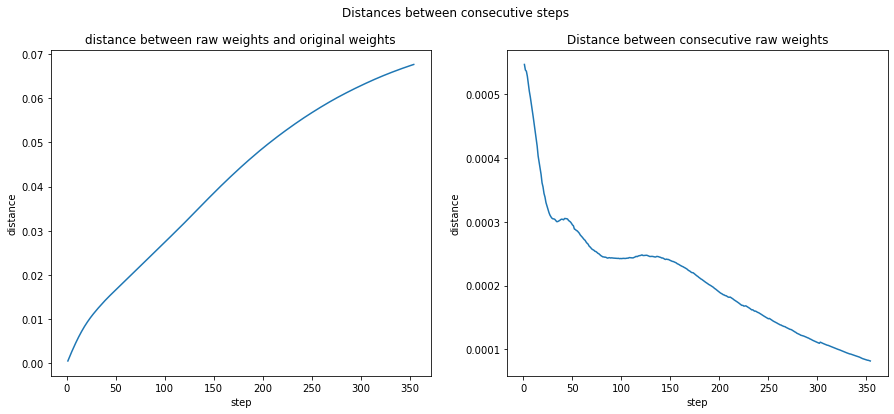

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(np.arange(1, len(data_1)), dist_from_original)
ax[0].set_title('distance between raw weights and original weights')
ax[0].set_xlabel('step')
ax[0].set_ylabel('distance')

ax[1].plot(np.arange(1, len(data_1)), dist_consecutive)
ax[1].set_title('Distance between consecutive raw weights')
ax[1].set_xlabel('step')
ax[1].set_ylabel('distance')

fig.suptitle('Distances between consecutive steps')

plt.show()

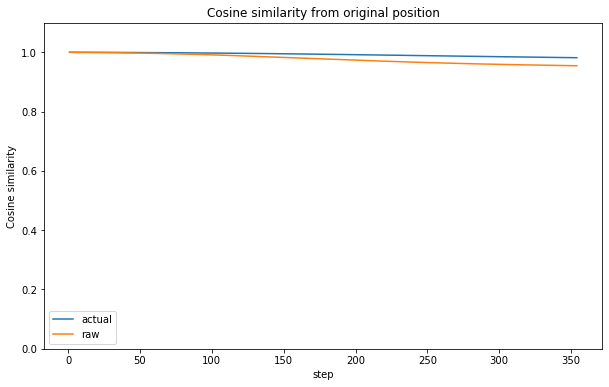

In [37]:
w_1_vec = np.concatenate([w.flatten() for w in raw_weights[0]]).reshape(1, -1)
cosangles = []
cosangles_raw = []
for i in np.arange(1, len(data_1)):
    
    w_2_vec = np.concatenate([w.flatten() for w in data_1[i]['w']]).reshape(1, -1)
    w_2_vec_raw = np.concatenate([w.flatten() for w in raw_weights[i]]).reshape(1, -1)
    cosangles += [cosine_similarity(w_1_vec, w_2_vec)]
    cosangles_raw += [cosine_similarity(w_1_vec, w_2_vec_raw)]
    
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(list(np.arange(1, len(data_1))), np.array(cosangles).flatten(), label='actual')
ax.plot(list(np.arange(1, len(data_1))), np.array(cosangles_raw).flatten(), label='raw')
ax.set_ylim([0, 1.1])
ax.set_title('Cosine similarity from original position')
ax.set_ylabel('Cosine similarity')
ax.set_xlabel('step')
ax.legend()

plt.show()